In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import qutip as qt

In [2]:
%load_ext autoreload
%autoreload 1

%aimport pypulse
%aimport pypulse.visualization

import pypulse
import pypulse.visualization as viz

In [3]:
if 'berkeley' in plt.style.available:
    plt.style.use('berkeley')

# DRAG

In [4]:
N=5

TWOPI = 2*np.pi
f01 = 5.6e9
f12 = 5.4e9

Ec, Ej = pypulse.systems.Transmon.compute_transmon_parameters(f01/1e9, (f12 - f01)/1e9)

tmon = pypulse.systems.Transmon(Ec*1e9, Ej*1e9)

print(tmon.omega/TWOPI)
print(tmon.omega/TWOPI + tmon.alpha/TWOPI)

5599372885.047562
5398916490.699883


## System

In [5]:
# Defining operators
H0 = tmon.eigenbasis(N)
a = qt.destroy(N)

psis = [qt.basis(N, i) for i in range(N)]
N_ops = [psi*psi.dag() for psi in psis]
P_ops = [pypulse.expand_operator_dim(p, N) for p in [qt.sigmax(), qt.sigmay(), qt.sigmaz()]]

## Pulse

In [6]:
sampling_rate = 2.5e9
pulse_duration = 12e-9
ramp_time = 4e-9

A = 62e6

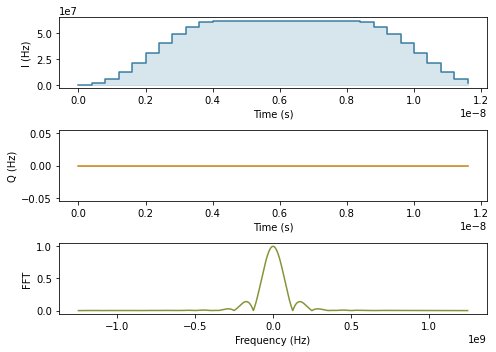

In [7]:
sample_ts = np.arange(sampling_rate*pulse_duration)/sampling_rate
cosine_pulse = pypulse.cosine_ramp(pulse_duration*sampling_rate, ramp_time*sampling_rate, A)

fig, ax = viz.plot_pulse(sample_ts, cosine_pulse)

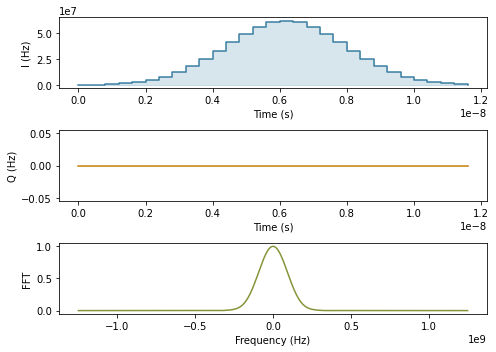

In [8]:
gaussian_pulse = pypulse.gaussian(pulse_duration*sampling_rate, 2*ramp_time*sampling_rate, A)

fig, ax = viz.plot_pulse(sample_ts, gaussian_pulse)

In [16]:
ts, cos_drive = pypulse.upconvert(cosine_pulse, f01, sampling_rate=sampling_rate, time_steps_per_sample=20, interpolate='linear')

# H = [[H0, np.ones_like(ts)], [a, 0.5*drive], [a.dag(), 0.5*np.conj(drive)]]
H = [[H0, np.ones_like(ts)], [a + a.dag(), np.real(cos_drive)]]

results = qt.mesolve(H, psis[0], ts, e_ops=N_ops)

(-0.05, 0.05)

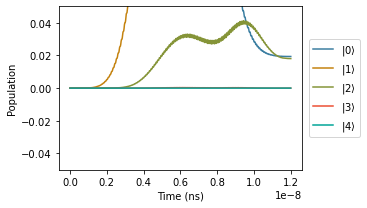

In [17]:
fig, ax = viz.plot_populations(ts, results.expect)
ax.set_ylim(-0.05, 0.05)

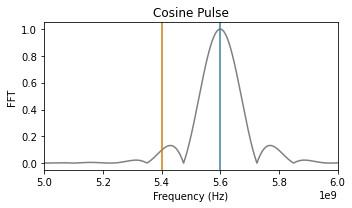

In [18]:
fig, ax = viz.plot_fft(ts, cos_drive, dB=False, flist=[f01, f12])
ax.set_xlim(5e9, 6e9)
ax.set_title('Cosine Pulse')
fig.tight_layout()

## Apply DRAG

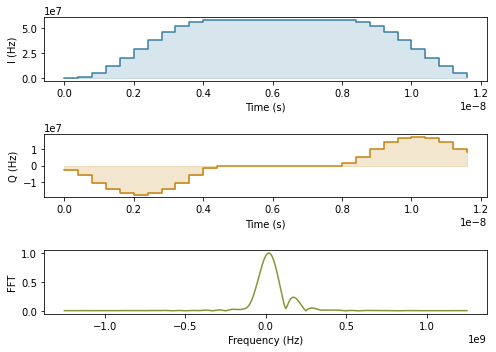

In [19]:
drag_pulse = pypulse.drag(sample_ts, cosine_pulse, lmbda=1/(TWOPI*(f12-f01)))

fig, ax = viz.plot_pulse(sample_ts, drag_pulse)

In [20]:
ts, drag_drive = pypulse.upconvert(drag_pulse, f01, sampling_rate=sampling_rate, time_steps_per_sample=20, interpolate='linear')

# H = [[H0, np.ones_like(ts)], [a, 0.5*drive], [a.dag(), 0.5*np.conj(drive)]]
H = [[H0, np.ones_like(ts)], [a + a.dag(), np.real(drag_drive)]]

results = qt.mesolve(H, psis[0], ts, e_ops=N_ops)

(-0.05, 0.05)

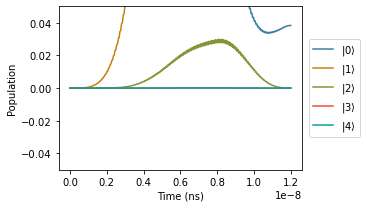

In [21]:
fig, ax = viz.plot_populations(ts, results.expect)
ax.set_ylim(-0.05, 0.05)

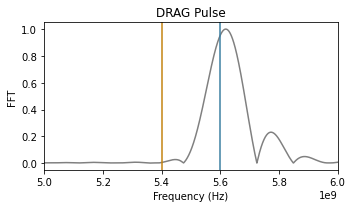

In [22]:
fig, ax = viz.plot_fft(ts, drag_drive, dB=False, flist=[f01, f12])
ax.set_xlim(5e9, 6e9)
ax.set_title('DRAG Pulse')
fig.tight_layout()